<a href="https://colab.research.google.com/github/AbigailMRod/GANsDL.AI/blob/main/Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Augmentation

En este cuaderno, se construirá un generador que se puede usar para ayudar a crear datos para entrenar un clasificador. Hay muchos casos en los que esto podría ser útil. Si está interesado en alguno de estos temas, puede explorar los documentos y artículos vinculados.

- Con conjuntos de datos más pequeños, las GAN pueden proporcionar un aumento de datos útil que sustancialmente [mejora el rendimiento del clasificador](https://arxiv.org/abs/1711.04340).
- Tiene un tipo de datos ya etiquetado y le gustaría hacer predicciones sobre [otro conjunto de datos relacionado para el que no tiene etiquetas](https://www.nature.com/articles/s41598-019-52737-x). (¡Aprenderá sobre las técnicas para este caso de uso en cuadernos futuros!)
- Quieres proteger la privacidad de las personas que proporcionaron su información para poder brindar acceso a un [generador en lugar de datos reales](https://www.ahajournals.org/doi/full/10.1161/CIRCOUTCOMES.118.005122).
- Tiene [datos de entrada con muchos valores faltantes](https://arxiv.org/abs/1806.02920), donde las dimensiones de entrada están correlacionadas y le gustaría entrenar un modelo con entradas completas.
- Le gustaría poder identificar una característica anormal del mundo real en una imagen [con fines de diagnóstico](https://link.springer.com/chapter/10.1007/978-3-030-00946-5_11) , pero tienen acceso limitado a ejemplos reales de la condición.



## Empezando

### Aumento de datos
Antes de implementar el aumento de datos basado en GAN, debe saber un poco sobre el aumento de datos en general, específicamente para conjuntos de datos de imágenes. Es una [práctica muy común](https://arxiv.org/abs/1712.04621) aumentar los conjuntos de datos basados ​​en imágenes de manera apropiada para un conjunto de datos determinado. Esto puede incluir que su cargador de datos voltee imágenes aleatoriamente a lo largo de su eje vertical, recorte aleatoriamente su imagen a un tamaño particular, agregue aleatoriamente un poco de ruido o color a una imagen de manera que sea real.

En general, el aumento de datos ayuda a evitar que su modelo se ajuste demasiado a los datos y le permite hacer pequeños conjuntos de datos muchas veces más grandes. Sin embargo, un clasificador lo suficientemente poderoso a menudo aún se adapta a los ejemplos originales, razón por la cual las GAN son particularmente útiles aquí. Pueden generar nuevas imágenes en lugar de simplemente modificar las existentes.

### CIFAR
Los conjuntos de datos [CIFAR-10 y CIFAR-100](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) se utilizan de forma muy amplia en el aprendizaje automático y contienen muchos miles de imágenes pequeñas en color de 32x32 de diferentes clases que representan objetos del mundo real relativamente comunes como aviones y perros, con 10 clases en CIFAR-10 y 100 clases en CIFAR-100. En CIFAR-100, hay 20 "superclases" que contienen cinco clases cada una. Por ejemplo, la superclase "peces" contiene "peces de acuario, peces planos, rayas, tiburones, truchas". Para los fines de esta tarea, observará un pequeño subconjunto de estas imágenes para simular un régimen de datos pequeño, con solo 40 imágenes de cada clase para entrenamiento.
<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png">


### Inicializaciones
Comenzará importando algunas bibliotecas y paquetes útiles y definiendo una función de visualización que se ha proporcionado. También reutilizará su generador condicional y el código de funciones de asignaciones anteriores. Esto le permitirá controlar qué clase de imágenes aumentar para su clasificador.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
torch.manual_seed(0) 

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32), nrow=5, show=True):
    '''
    Función de visualización de imágenes: Dado un tensor de imágenes, número de imágenes y
     tamaño por imagen, traza e imprime las imágenes en una cuadrícula uniforme.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

Generador

In [ ]:
class Generator(nn.Module):
    '''
    Clase de generador
     Valores:
         input_dim: la dimensión del vector de entrada, un escalar
         im_chan: el número de canales de la imagen de salida, un escalar
               (CIFAR100 está en color (rojo, verde, azul), por lo que 3 es su valor predeterminado)
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, input_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Construir la red neuronal
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4, kernel_size=4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=2, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque generador de DCGAN;
         una convolución transpuesta, una norma por lotes (excepto en la capa final) y una activación.
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Función para completar un paso hacia adelante del generador: Dado un tensor de ruido,
         devuelve las imágenes generadas.
         Parámetros:
             noise: un tensor de ruido con dimensiones (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Función para crear vectores de ruido: Dadas las dimensiones (n_samples, input_dim)
     crea un tensor de esa forma lleno de números aleatorios de la distribución normal.
     Parámetros:
         n_samples: el número de muestras a generar, un escalar
         input_dim: la dimensión del vector de entrada, un escalar
         device: el tipo de dispositivo
    '''
    return torch.randn(n_samples, input_dim, device=device)

def combine_vectors(x, y):
    '''
    Función para combinar dos vectores con formas (n_samples, ?) y (n_samples, ?)
     Parámetros:
     x: (n_muestras, ?) el primer vector.
         En esta asignación, este será el vector de ruido de forma (n_samples, z_dim),
         pero no debería necesitar saber el tamaño de la segunda dimensión.
     y: (n_muestras, ?) el segundo vector.
         Una vez más, en esta tarea, este será el vector de clase one-hot
         con la forma (n_samples, n_classes), pero no debe asumir esto en su código.
    '''
    return torch.cat([x, y], 1)

def get_one_hot_labels(labels, n_classes):
    '''
    Función para combinar dos vectores con formas (n_samples, ?) y (n_samples, ?)
     Parámetros:
     labels: (n_muestras, 1)
     n_classes: un entero único correspondiente al número total de clases en el conjunto de datos
    '''
    return F.one_hot(labels, n_classes)

## Entrenamiento
Ahora puede comenzar a entrenar sus modelos.
Primero, definirá algunos parámetros nuevos:

* cifar100_shape: el número de píxeles en cada imagen CIFAR, que tiene unas dimensiones de 32 x 32 y tres canales (para rojo, verde y azul), es decir, 3 x 32 x 32
* n_classes: el número de clases en CIFAR100 (por ejemplo, avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión)

In [ ]:
cifar100_shape = (3, 32, 32)
n_classes = 100

Y también incluye los mismos parámetros de asignaciones anteriores:

   * criterion: la función de pérdida
   * n_epochs: la cantidad de veces que itera a través de todo el conjunto de datos durante el entrenamiento
   * z_dim: la dimensión del vector de ruido
   * display_step: con qué frecuencia mostrar/visualizar las imágenes
   * batch_size: el número de imágenes por paso adelante/atrás
   * lr: la tasa de aprendizaje
   * device: el tipo de dispositivo

In [ ]:
n_epochs = 10000
z_dim = 64
display_step = 500
batch_size = 64
lr = 0.0002
device = 'cuda'

Luego, desea establecer la dimensión de entrada de su generador. Recuerde que para las GAN condicionales, la entrada del generador es el vector de ruido concatenado con el vector de clase.

In [ ]:
generator_input_dim = z_dim + n_classes

#### Clasificador




In [ ]:
class Classifier(nn.Module):
    '''
    Clase de clasificador
     Valores:
         im_chan: el número de canales de la imagen de salida, un escalar
         n_classes: el número total de clases en el conjunto de datos, un escalar entero
         hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, im_chan, n_classes, hidden_dim=32):
        super(Classifier, self).__init__()
        self.disc = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque clasificador;
         una convolución, una norma por lotes (excepto en la capa final) y una activación (excepto en la capa final).
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante del clasificador: Dado un tensor de imagen,
         devuelve un tensor n_classes-dimension que representa falso/real.
         Parámetros:
             image: un tensor de imagen aplanado con canales im_chan
        '''
        class_pred = self.disc(image)
        return class_pred.view(len(class_pred), -1)

#### Pre-entrenamiento (Opcional)

Se le proporciona el código para entrenar previamente los modelos (GAN y clasificador) que se le entregaron en esta tarea. Sin embargo, esto está destinado solo para su curiosidad personal: para que la tarea se ejecute según lo previsto, no debe usar ningún punto de control además de los que se le otorgan.

In [ ]:
# Este código está aquí para que entrenes tu propio generador o clasificador
# fuera de la asignación en el conjunto de datos completo si lo desea, a los efectos
# de esta tarea, utilice los puntos de control provistos
class Discriminator(nn.Module):
    '''
    Clase de discriminador
     Valores:
       im_chan: el número de canales de la imagen de salida, un escalar
             (MNIST es en blanco y negro, por lo que 1 canal es su valor predeterminado)
       hidden_dim: la dimensión interna, un escalar
    '''
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim, stride=1),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Función para devolver una secuencia de operaciones correspondiente a un bloque discriminador de la DCGAN;
         una convolución, una norma por lotes (excepto en la capa final) y una activación (excepto en la capa final).
         Parámetros:
             input_channels: cuántos canales tiene la representación de la característica de entrada
             output_channels: cuántos canales debe tener la representación de la característica de salida
             kernel_size: el tamaño de cada filtro convolucional, equivalente a (kernel_size, kernel_size)
             stride: la zancada de la convolución
             final_layer: un valor booleano, verdadero si es la capa final y falso en caso contrario
                       (afecta la activación y la norma de lote)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Función para completar un pase hacia adelante del discriminador: Dado un tensor de imagen,
         devuelve un tensor de 1 dimensión que representa falso/real.
         Parámetros:
             image: un tensor de imagen aplanado con dimensión (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

def train_generator():
    gen = Generator(generator_input_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
    discriminator_input_dim = cifar100_shape[0] + n_classes
    disc = Discriminator(discriminator_input_dim).to(device)
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

    criterion = nn.BCEWithLogitsLoss()
    cur_step = 0
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    for epoch in range(n_epochs):
        # Dataloader devuelve los lotes y las etiquetas
        for real, labels in dataloader:
            cur_batch_size = len(real)
            # Aplane el lote de imágenes reales del conjunto de datos
            real = real.to(device)

            # Convierta las etiquetas del cargador de datos en versiones únicas de esas etiquetas
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = image_one_hot_labels.repeat(1, 1, cifar100_shape[1], cifar100_shape[2])

            ### Actualizar el discriminador ###
            # Poner a cero los gradientes del discriminador
            disc_opt.zero_grad()
            # Obtenga el ruido correspondiente al tamaño del lote actual
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
            # Combine los vectores del ruido y las etiquetas one-hot para el generador
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)
            # Combine los vectores de las imágenes y las etiquetas one-hot para el discriminador
            fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
            real_image_and_labels = combine_vectors(real, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            disc_real_pred = disc(real_image_and_labels)

            disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True)
            disc_opt.step() 

            # Realice un seguimiento de la pérdida promedio del discriminador
            mean_discriminator_loss += disc_loss.item() / display_step

            ### Actualizar el generador ###
            # Poner en cero los gradientes del generador
            gen_opt.zero_grad()

            # Pase al discriminador la combinación de las imágenes falsas y las etiquetas one-hot
            fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            gen_opt.step()

            # Lleve un registro de la pérdida promedio del generador
            mean_generator_loss += gen_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
                show_tensor_images(fake)
                show_tensor_images(real)
                mean_generator_loss = 0
                mean_discriminator_loss = 0
            cur_step += 1

def train_classifier():
    criterion = nn.CrossEntropyLoss()
    n_epochs = 10

    validation_dataloader = DataLoader(
        CIFAR100(".", train=False, download=True, transform=transform),
        batch_size=batch_size)

    display_step = 10
    batch_size = 512
    lr = 0.0002

    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    for epoch in range(n_epochs):
        for real, labels in tqdm(dataloader):
            cur_batch_size = len(real)
            real = real.to(device)
            labels = labels.to(device)

            ### Actualizar el clasificador ###
            # Obtenga el ruido correspondiente al tamaño del lote actual
            classifier_opt.zero_grad()
            labels_hat = classifier(real.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            if cur_step % display_step == 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                for val_example, val_label in validation_dataloader:
                    cur_batch_size = len(val_example)
                    num_validation += cur_batch_size
                    val_example = val_example.to(device)
                    val_label = val_label.to(device)
                    labels_hat = classifier(val_example)
                    classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                    classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()

                print(f"Step {cur_step}: "
                        f"Classifier loss: {classifier_val_loss.item() / num_validation}, "
                        f"classifier accuracy: {classifier_correct.item() / num_validation}")
            cur_step += 1

## Afinando el Clasificador
Como maestro de errores, desea un clasificador capaz de clasificar diferentes especies de insectos: abejas, escarabajos, mariposas, orugas y más. Afortunadamente, encontraste un gran conjunto de datos con muchas especies de animales y objetos, y entrenaste a tu clasificador en eso.

Pero las clases de errores no funcionan tan bien como te gustaría. ¡Ahora su plan es entrenar un GAN con los mismos datos para que pueda generar nuevos errores para que su clasificador distinga mejor entre todos sus errores favoritos!

Ajustará su modelo aumentando los datos reales originales con datos falsos y, durante ese proceso, observará cómo aumentar la precisión de su clasificador con estos errores falsos generados por GAN. Después de esto, demostrarás tu valía como maestro de errores.

#### Relación de muestreo

Supongamos que ha decidido que, aunque tiene este generador general preentrenado y este clasificador general, capaz de identificar 100 clases con cierta precisión (~17 %), lo que realmente le gustaría es un modelo que pueda clasificar las cinco clases diferentes. tipos de errores en el conjunto de datos. Ajustará su modelo aumentando sus datos con las imágenes generadas. Tenga en cuenta que tanto el generador como el clasificador se entrenaron con las mismas imágenes: las 40 imágenes por clase que encontró minuciosamente, por lo que su generador puede no ser excelente. Esta es la advertencia con el aumento de datos, en última instancia, todavía está limitado por los datos reales que tiene, pero desea intentar crear más. Para hacer que sus modelos sean aún mejores, necesitará tomar más fotos de errores, etiquetarlos y agregarlos a su conjunto de entrenamiento y/o usar fotos de mayor calidad.

Para comenzar, primero deberá escribir un código para probar una combinación de imágenes reales y generadas. Dada una probabilidad, `p_real`, deberá generar un tensor combinado donde aproximadamente `p_real` de las imágenes devueltas se muestrean de las imágenes reales. Tenga en cuenta que no debe interpolar las imágenes aquí: debe elegir cada imagen del conjunto real o falso con una probabilidad dada. Por ejemplo, si sus imágenes reales son un tensor de `[[1, 2, 3, 4, 5]]` y sus imágenes falsas son un tensor de `[[-1, -2, -3, -4, - 5]]` y `p_real = 0.2`, dos posibles valores de retorno aleatorios son `[[1, -2, 3, -4, -5]]` o `[[-1, 2, -3, -4 , -5]]`.


Tenga en cuenta que `p_real = 0.2` no garantiza que exactamente el 20% de las muestras sean reales, solo que al elegir una imagen para el conjunto combinado, existe un 20% de probabilidad de que esa imagen se elija entre las imágenes reales, y un 80% de probabilidad de que sea seleccionado de las imágenes falsas.

Además, esperamos que las imágenes permanezcan en el mismo orden para mantener su alineación con sus etiquetas (¡esto también se aplica a las imágenes falsas!)

In [ ]:
def combine_sample(real, fake, p_real):
    '''
    Función para tomar un conjunto de imágenes reales y falsas de la misma longitud (x)
     y producir un tensor combinado con longitud (x) y muestreado en la probabilidad objetivo
     Parámetros:
         real: un tensor de imágenes reales, longitud (x)
         fake: un tensor de imágenes falsas, longitud (x)
         p_real: la probabilidad de que las imágenes se muestreen del conjunto real
    '''
    #### START CODE HERE ####
    make_fake = torch.rand(len(real)) > p_real
    target_images = real.clone()
    target_images[make_fake] = fake[make_fake]
    #### END CODE HERE ####
    return target_images

In [ ]:
n_test_samples = 9999
test_combination = combine_sample(
    torch.ones(n_test_samples, 1), 
    torch.zeros(n_test_samples, 1), 
    0.3
)
# Comprueba que la forma sea la correcta
assert tuple(test_combination.shape) == (n_test_samples, 1)
# Check that the ratio is right
assert torch.abs(test_combination.mean() - 0.3) < 0.05
# Asegúrese de que no haya ocurrido ninguna mezcla
assert test_combination.median() < 1e-5

test_combination = combine_sample(
    torch.ones(n_test_samples, 10, 10), 
    torch.zeros(n_test_samples, 10, 10), 
    0.8
)
# Comprueba que la forma sea la correcta
assert tuple(test_combination.shape) == (n_test_samples, 10, 10)
# Asegúrese de que no haya ocurrido ninguna mezcla
assert torch.abs((test_combination.sum([1, 2]).median()) - 100) < 1e-5

test_reals = torch.arange(n_test_samples)[:, None].float()
test_fakes = torch.zeros(n_test_samples, 1)
test_saved = (test_reals.clone(), test_fakes.clone())
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Asegúrese de que la muestra no esté sesgada
assert torch.abs((test_combination.mean() - 1500)) < 100
# Asegúrese de que no se cambiaron las entradas
assert torch.abs(test_saved[0] - test_reals).sum() < 1e-3
assert torch.abs(test_saved[1] - test_fakes).sum() < 1e-3

test_fakes = torch.arange(n_test_samples)[:, None].float()
test_combination = combine_sample(test_reals, test_fakes, 0.3)
# Asegúrate de que se mantenga el orden.
assert torch.abs(test_combination - test_reals).sum() < 1e-4
if torch.cuda.is_available():
    # Verifique que la solución coincida con el dispositivo de entrada
    assert str(combine_sample(
        torch.ones(n_test_samples, 10, 10).cuda(), 
        torch.zeros(n_test_samples, 10, 10).cuda(),
        0.8
    ).device).startswith("cuda")
print("Success!")

Success!


## Parte opcional: Entrenamiento

Ahora tienes un desafío: encuentra un `p_real` y una imagen generadora de modo que tu clasificador obtenga un promedio de 51% de precisión o más en los insectos, cuando se evalúa con la función `eval_augmentation`. ** ¡Deberá completar `find_optimal` para encontrar estos parámetros para resolver esta parte! ** Tenga en cuenta que si su respuesta tarda mucho tiempo en ejecutarse, es posible que deba codificar la solución que encuentra.

Cuando está entrenando un generador, a menudo tendrá que mirar diferentes puntos de control y elegir uno que funcione mejor (ya sea empíricamente o usando algún método de evaluación). Aquí, se le proporcionan cuatro puntos de control del generador: `gen_1.pt`, `gen_2.pt`, `gen_3.pt`, `gen_4.pt`. También tendrá un área de borrador para escribir el código que desee para resolver este problema, pero debe devolver un `p_real` y un nombre de imagen de su punto de control del generador seleccionado. Puede codificar/forzar brutamente estos números si lo desea, pero se le recomienda que intente resolver este problema de una manera más general. En la práctica, también desearía un conjunto de prueba (ya que es posible sobreajustar en un conjunto de validación), pero para simplificar, puede concentrarse en el conjunto de validación.

In [ ]:
!git clone https://github.com/AbigailMRod/GANsDL.AI.git

Cloning into 'GANsDL.AI'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (66/66), done.


In [ ]:
def find_optimal():
    # En la siguiente sección, puede escribir el código para elegir su respuesta óptima
     # ¡Incluso puede usar la función eval_augmentation en su código si lo desea!
    gen_names = [
        "/content/GANsDL.AI/gen/gen_1.pt",
        "/content/GANsDL.AI/gen/gen_2.pt",
        "/content/GANsDL.AI/gen/gen_3.pt",
        "/content/GANsDL.AI/gen/gen_4.pt"
    ]

    #### START CODE HERE #### 
    best_p_real, best_gen_name = 0.6, "/content/GANsDL.AI/gen/gen_4.pt"
    #### END CODE HERE ####
    return best_p_real, best_gen_name

def augmented_train(p_real, gen_name):
    gen = Generator(generator_input_dim).to(device)
    gen.load_state_dict(torch.load(gen_name))

    classifier = Classifier(cifar100_shape[0], n_classes).to(device)
    classifier.load_state_dict(torch.load("/content/GANsDL.AI/gen/class.pt"))
    criterion = nn.CrossEntropyLoss()
    batch_size = 256

    train_set = torch.load("/content/GANsDL.AI/gen/insect_train.pt")
    val_set = torch.load("/content/GANsDL.AI/gen/insect_val.pt")
    dataloader = DataLoader(
        torch.utils.data.TensorDataset(train_set["images"], train_set["labels"]),
        batch_size=batch_size,
        shuffle=True
    )
    validation_dataloader = DataLoader(
        torch.utils.data.TensorDataset(val_set["images"], val_set["labels"]),
        batch_size=batch_size
    )

    display_step = 1
    lr = 0.0002
    n_epochs = 20
    classifier_opt = torch.optim.Adam(classifier.parameters(), lr=lr)
    cur_step = 0
    best_score = 0
    for epoch in range(n_epochs):
        for real, labels in dataloader:
            real = real.to(device)
            # Aplanar la imagen
            labels = labels.to(device)
            one_hot_labels = get_one_hot_labels(labels.to(device), n_classes).float()

            ### Actualizar el clasificador ###
            # Obtenga el ruido correspondiente al tamaño del lote actual
            classifier_opt.zero_grad()
            cur_batch_size = len(labels)
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
            fake = gen(noise_and_labels)

            target_images = combine_sample(real.clone(), fake.clone(), p_real)
            labels_hat = classifier(target_images.detach())
            classifier_loss = criterion(labels_hat, labels)
            classifier_loss.backward()
            classifier_opt.step()

            # Calcule la precisión en el conjunto de validación
            if cur_step % display_step == 0 and cur_step > 0:
                classifier_val_loss = 0
                classifier_correct = 0
                num_validation = 0
                with torch.no_grad():
                    for val_example, val_label in validation_dataloader:
                        cur_batch_size = len(val_example)
                        num_validation += cur_batch_size
                        val_example = val_example.to(device)
                        val_label = val_label.to(device)
                        labels_hat = classifier(val_example)
                        classifier_val_loss += criterion(labels_hat, val_label) * cur_batch_size
                        classifier_correct += (labels_hat.argmax(1) == val_label).float().sum()
                    accuracy = classifier_correct.item() / num_validation
                    if accuracy > best_score:
                        best_score = accuracy
            cur_step += 1
    return best_score

def eval_augmentation(p_real, gen_name, n_test=20):
    total = 0
    for i in range(n_test):
        total += augmented_train(p_real, gen_name)
    return total / n_test

best_p_real, best_gen_name = find_optimal()
performance = eval_augmentation(best_p_real, best_gen_name)
print(f"Your model had an accuracy of {performance:0.1%}")
assert performance > 0.512
print("Success!")

Your model had an accuracy of 51.8%
Success!


Probablemente encontrará que el peor rendimiento es cuando el generador funciona solo: esto corresponde al caso en el que podría estar tratando de ocultar los ejemplos subyacentes del clasificador. ¡Quizás no quiera que otras personas sepan acerca de sus errores específicos!

  0%|          | 0/21 [00:00<?, ?it/s]

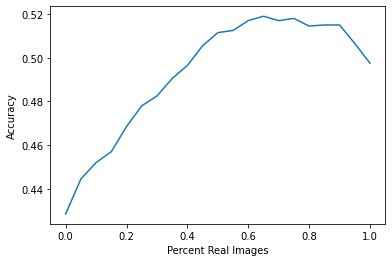

In [ ]:
accuracies = []
p_real_all = torch.linspace(0, 1, 21)
for p_real_vis in tqdm(p_real_all):
    accuracies += [eval_augmentation(p_real_vis, best_gen_name, n_test=4)]
plt.plot(p_real_all.tolist(), accuracies)
plt.ylabel("Accuracy")
_ = plt.xlabel("Percent Real Images")

Aquí hay una visualización de lo que el generador realmente está generando, con ejemplos reales de cada clase sobre la imagen generada correspondiente.

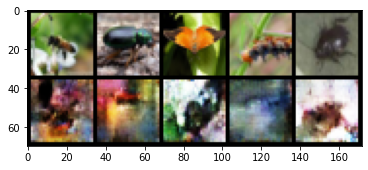

In [ ]:
examples = [4, 41, 80, 122, 160]
train_images = torch.load("/content/GANsDL.AI/gen/insect_train.pt")["images"][examples]
train_labels = torch.load("/content/GANsDL.AI/gen/insect_train.pt")["labels"][examples]

one_hot_labels = get_one_hot_labels(train_labels.to(device), n_classes).float()
fake_noise = get_noise(len(train_images), z_dim, device=device)
noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
gen = Generator(generator_input_dim).to(device)
gen.load_state_dict(torch.load(best_gen_name))

fake = gen(noise_and_labels)
show_tensor_images(torch.cat([train_images.cpu(), fake.cpu()]))